In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import PIL
from PIL import Image
import io
from tqdm import tqdm
tf.compat.v1.enable_eager_execution()

2025-07-28 11:49:24.423019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753703364.617933      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753703364.672854      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1
IMG_HEIGHT = 256
IMG_WIDTH = 256

MONET_TFREC_PATH = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
PHOTO_TFREC_PATH = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'
OUTPUT_DIR = './monet_generated_images'
ZIP_NAME = 'images.zip'

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
def parse_image(example_proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(example_proto, features)
    image = tf.image.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(tf.io.gfile.glob(MONET_TFREC_PATH)).cache().shuffle(300).batch(BATCH_SIZE)
photo_ds = load_dataset(tf.io.gfile.glob(PHOTO_TFREC_PATH)).cache().shuffle(1000).batch(BATCH_SIZE)

print(monet_ds)

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


I0000 00:00:1753703377.051898      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753703377.052512      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


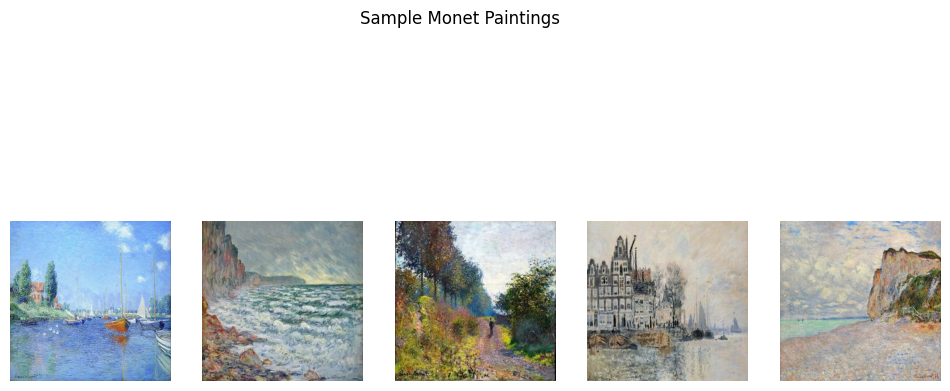

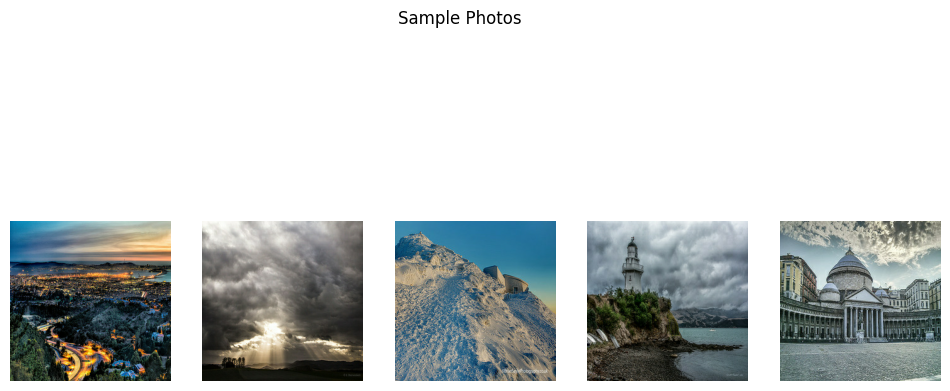

In [5]:
def show_images(dataset, title):
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(dataset.take(5)):
        plt.subplot(1, 5, i+1)
        plt.imshow((img[0] + 1) / 2)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(monet_ds, 'Sample Monet Paintings')
show_images(photo_ds, 'Sample Photos')

In [6]:
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

In [7]:

def Generator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(256, 4, apply_dropout=True),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
    x = inp
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1,
                      kernel_initializer=initializer,
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1,
                      kernel_initializer=initializer)(x)
    return tf.keras.Model(inputs=inp, outputs=x)


In [8]:
monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
monet_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [9]:

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, lambda_cycle):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss

def calc_id_loss(real_image, same_image, lambda_id):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_id * 0.5 * loss

In [10]:

tf.compat.v1.enable_eager_execution()
best_score = -1
best_generator = None
best_lambda_id = 0
best_lambda_cycle = 0

for lambda_id, lambda_cycle in {(i, j) for i in range(5,20,5) for j in range(5,20,5)}:
    monet_generator = Generator()
    photo_generator = Generator()
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()
    
    @tf.function
    def train_step(real_monet, real_photo):
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = monet_generator(real_photo, training=True)
            cycled_photo = photo_generator(fake_monet, training=True)
    
            fake_photo = photo_generator(real_monet, training=True)
            cycled_monet = monet_generator(fake_photo, training=True)
    
            same_monet = monet_generator(real_monet, training=True)
            same_photo = photo_generator(real_photo, training=True)
    
            disc_real_monet = monet_discriminator(real_monet, training=True)
            disc_real_photo = photo_discriminator(real_photo, training=True)
    
            disc_fake_monet = monet_discriminator(fake_monet, training=True)
            disc_fake_photo = photo_discriminator(fake_photo, training=True)
    
            gen_monet_loss = generator_loss(disc_fake_monet)
            gen_photo_loss = generator_loss(disc_fake_photo)
    
            total_cycle_loss = calc_cycle_loss(real_monet, cycled_monet, lambda_cycle) + calc_cycle_loss(real_photo, cycled_photo, lambda_cycle)
            total_gen_monet_loss = gen_monet_loss + total_cycle_loss + calc_id_loss(real_monet, same_monet, lambda_id)
            total_gen_photo_loss = gen_photo_loss + total_cycle_loss + calc_id_loss(real_photo, same_photo, lambda_id)
    
            disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
            disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
    
        monet_gen_grads = tape.gradient(total_gen_monet_loss, monet_generator.trainable_variables)
        photo_gen_grads = tape.gradient(total_gen_photo_loss, photo_generator.trainable_variables)
    
        monet_disc_grads = tape.gradient(disc_monet_loss, monet_discriminator.trainable_variables)
        photo_disc_grads = tape.gradient(disc_photo_loss, photo_discriminator.trainable_variables)
    
        monet_gen_optimizer.apply_gradients(zip(monet_gen_grads, monet_generator.trainable_variables))
        photo_gen_optimizer.apply_gradients(zip(photo_gen_grads, photo_generator.trainable_variables))
    
        monet_disc_optimizer.apply_gradients(zip(monet_disc_grads, monet_discriminator.trainable_variables))
        photo_disc_optimizer.apply_gradients(zip(photo_disc_grads, photo_discriminator.trainable_variables))

    try:
        for epoch in range(5):
            print(f"Epoch {epoch+1}/5")
            for real_monet, real_photo in tf.data.Dataset.zip((monet_ds, photo_ds)):
                train_step(real_monet, real_photo)
    
        # Evaluate losses over a small subset
        val_monet_ds = monet_ds.take(10)
        val_photo_ds = photo_ds.take(10)
    
        total_gen_loss = 0.0
        total_disc_loss = 0.0
        val_batches = 0
    
        for real_monet, real_photo in tf.data.Dataset.zip((val_monet_ds, val_photo_ds)):
            # Generator forward passes
            fake_monet = monet_generator(real_photo, training=False)
            fake_photo = photo_generator(real_monet, training=False)
    
            cycled_photo = photo_generator(fake_monet, training=False)
            cycled_monet = monet_generator(fake_photo, training=False)
    
            same_monet = monet_generator(real_monet, training=False)
            same_photo = photo_generator(real_photo, training=False)
    
            # Discriminator forward passes
            disc_real_monet = monet_discriminator(real_monet, training=False)
            disc_fake_monet = monet_discriminator(fake_monet, training=False)
            disc_real_photo = photo_discriminator(real_photo, training=False)
            disc_fake_photo = photo_discriminator(fake_photo, training=False)
    
            # Loss calculations
            gen_monet_loss = generator_loss(disc_fake_monet)
            gen_photo_loss = generator_loss(disc_fake_photo)
            cycle_loss = calc_cycle_loss(real_monet, cycled_monet, lambda_cycle) + calc_cycle_loss(real_photo, cycled_photo, lambda_cycle)
            id_loss = calc_id_loss(real_monet, same_monet, lambda_id) + calc_id_loss(real_photo, same_photo, lambda_id)
    
            total_gen = (gen_monet_loss + gen_photo_loss + cycle_loss + id_loss).numpy()
            total_disc = (discriminator_loss(disc_real_monet, disc_fake_monet) + discriminator_loss(disc_real_photo, disc_fake_photo)).numpy()
    
            total_gen_loss += total_gen
            total_disc_loss += total_disc
            val_batches += 1
    
        avg_gen_loss = total_gen_loss / val_batches
        avg_disc_loss = total_disc_loss / val_batches
        total_score = avg_gen_loss + avg_disc_loss
    
        if total_score < best_score or best_score<0:
            best_score = total_score
            best_generator = tf.keras.models.clone_model(monet_generator)
            best_generator.set_weights(monet_generator.get_weights())
            best_lambda_id = lambda_id
            best_lambda_cycle = lambda_cycle
    except:
        pass
print(f"Best LAMBDA ID {best_lambda_id}")
print(f"Best LAMBDA CYCLE {best_lambda_cycle}")

Epoch 1/5


E0000 00:00:1753703401.817539      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_15_5/sequential_11_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1753703403.000625      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Best LAMBDA ID 10
Best LAMBDA CYCLE 15


In [11]:


photo_test_ds = load_dataset(tf.io.gfile.glob(PHOTO_TFREC_PATH)).batch(1)

for i, photo in enumerate(tqdm(photo_test_ds, total=7028)):
    monet_image = best_generator(photo, training=False)[0]
    monet_image = ((monet_image + 1.0) * 127.5).numpy().astype(np.uint8)
    im = Image.fromarray(monet_image)
    im.save(f"{OUTPUT_DIR}/{i}.jpg")

with zipfile.ZipFile("images.zip", "w") as zipf:
    for i in range(7028):
        zipf.write(f"{OUTPUT_DIR}/{i}.jpg", arcname=f"{i}.jpg")



7038it [02:38, 44.33it/s]
